# S2S RNN to predict next state

We aim to predict the next steps on time series

In [16]:
from __future__ import absolute_import, division, print_function, unicode_literals
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pprint as pprint
import math
import time

In [17]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.1.0


In [18]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import os
import json
import pickle
import sklearn
from sklearn import neighbors

In [19]:
import import_ipynb

import Process_Training_Data_2

from Process_Training_Data_2 import norm
from Process_Training_Data_2 import denorm
from Process_Training_Data_2 import class_to_action
from Process_Training_Data_2 import closest_category
from Process_Training_Data_2 import extend_dataset
from Process_Training_Data_2 import normalize_data
from Process_Training_Data_2 import print_model_df_analysis

### Get the data
First Import it using pandas

In [28]:
N_STEPS = 10

dataset_short = Process_Training_Data_2.get_data("./data/OSPA_training_data 2.csv")


#exteneded_dataset = Process_Training_Data_2.extend_dataset(dataset_short,N_STEPS)

action_vector = ["A0","A1"]
normed_dataset = Process_Training_Data_2.normalize_data(dataset_short, action_vector)

position = "post"
dataset2 = Process_Training_Data_2.padding(normed_dataset,N_STEPS,position)

In [21]:
Zero_Target= [0,0,0,0,0,0]
data_stats=pd.read_csv("./data/data_stats2.csv")
ZT_norm = norm(Zero_Target, data_stats)
ZT_norm 

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
5    0.0
Name: std, dtype: float64

### Split the data into train and test

Now split the dataset into a training set and a test set.

We take the first TRAIN_SPLIT values as train data

We will use the test set in the final evaluation of our model.

### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [30]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, prediction_type):
  data = []
  labels = []

  if end_index is None:
    end_index = len(dataset)

  for i in range(start_index, end_index):
    indices = range(0, len(dataset[i])-1)
    data.append(dataset[i,indices,:])

    if prediction_type is "single_step":
      labels.append(target[i,history_size + target_size])
    elif prediction_type is "multiple_step":
      labels.append(target[i,history_size:history_size+target_size])
    elif prediction_type  is "sequence":
      labels.append(target[i, 1:])   

  return np.array(data), np.array(labels)

## single step model using sequential output
Given a sequence of actions, the model should predict the same sequency one step in the future

### Split features from labels

In [31]:
np.random.shuffle(dataset2)

In [32]:
TRAIN_SPLIT = int(len(dataset2)*0.8)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,0:,:6]

x_train_single_sequential, y_train_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)

x_val_single_sequential, y_val_single_sequential = multivariate_data(features_dataset, target_dataset, TRAIN_SPLIT, None, past_history, future_target, STEP, prediction_type)

In [33]:
print ('Single window of past history : {}'.format(x_train_single_sequential[0].shape))

Single window of past history : (10, 6)


In [34]:
BATCH_SIZE = 1
# BUFFER_SIZE = 10000

train_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_train_single_sequential, y_train_single_sequential))
train_data_single_sequential = train_data_single_sequential.cache().batch(BATCH_SIZE).repeat()

val_data_single_sequential = tf.data.Dataset.from_tensor_slices((x_val_single_sequential, y_val_single_sequential))
val_data_single_sequential = val_data_single_sequential.batch(BATCH_SIZE).repeat()

In [35]:
x_train_single_sequential[0]

array([[ 2.29897636e+00, -2.21848399e+00, -1.04955781e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.10569589e+00, -2.03649336e+00, -1.73156561e+00,
        -1.33597795e+00,  1.42511551e+00,  9.29191277e-01],
       [ 1.79464288e+00, -1.62169639e+00, -2.58939761e+00,
        -1.87365888e+00,  9.82679201e-01, -7.09765638e-01],
       [ 1.38506516e+00, -1.10795353e+00, -3.19092275e+00,
        -7.37546892e-01,  1.51135560e+00,  3.88136061e-01],
       [ 9.29506304e-01, -3.09584667e-01, -3.84396703e+00,
        -5.80906326e-01,  1.84924892e+00,  2.44060806e-01],
       [ 3.54380889e-01,  2.27398864e-01, -3.70958780e+00,
        -2.06575308e+00,  5.01285408e-02, -1.49279373e+00],
       [ 1.77441433e-04,  3.64719000e-02, -2.78618581e+00,
        -2.32214049e+00, -1.49469491e+00, -1.62438432e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.000

In [36]:
y_train_single_sequential[0]

array([[ 2.10569589e+00, -2.03649336e+00, -1.73156561e+00,
        -1.33597795e+00,  1.42511551e+00,  9.29191277e-01],
       [ 1.79464288e+00, -1.62169639e+00, -2.58939761e+00,
        -1.87365888e+00,  9.82679201e-01, -7.09765638e-01],
       [ 1.38506516e+00, -1.10795353e+00, -3.19092275e+00,
        -7.37546892e-01,  1.51135560e+00,  3.88136061e-01],
       [ 9.29506304e-01, -3.09584667e-01, -3.84396703e+00,
        -5.80906326e-01,  1.84924892e+00,  2.44060806e-01],
       [ 3.54380889e-01,  2.27398864e-01, -3.70958780e+00,
        -2.06575308e+00,  5.01285408e-02, -1.49279373e+00],
       [ 1.77441433e-04,  3.64719000e-02, -2.78618581e+00,
        -2.32214049e+00, -1.49469491e+00, -1.62438432e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.000

### Build the model

sample_weight

In [37]:

sample_weight= tf.constant([[[1,1,1,1,1,1],[2,2,2,2,2,2],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3],[3,3,3,3,3,3]]])
sample_weight

<tf.Tensor: shape=(1, 8, 6), dtype=int32, numpy=
array([[[1, 1, 1, 1, 1, 1],
        [2, 2, 2, 2, 2, 2],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3],
        [3, 3, 3, 3, 3, 3]]])>

In [38]:
single_step_sequential_model = tf.keras.models.Sequential()
single_step_sequential_model.add(tf.keras.layers.LSTM(11,return_sequences=True, input_shape=(None, 6)))
single_step_sequential_model.add(tf.keras.layers.Dense(6, activation='linear'))

loss_fn = tf.keras.losses.MeanSquaredError(reduction='sum_over_batch_size')

single_step_sequential_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss=loss_fn, metrics=['mse','mae'])

### Inspect the model

In [39]:
single_step_sequential_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 11)          792       
_________________________________________________________________
dense (Dense)                (None, None, 6)           72        
Total params: 864
Trainable params: 864
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [40]:
STEPS_PER_EPOCH = TRAIN_SPLIT / BATCH_SIZE
EPOCHS = 100

single_step_sequential_history = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_data=val_data_single_sequential, validation_steps=50)

Train for 192.0 steps, validate for 50 steps
Epoch 1/100
192/192 [==============================] - 12s 62ms/step - loss: 1.1523 - mse: 1.1523 - mae: 0.7672 - val_loss: 0.6400 - val_mse: 0.6400 - val_mae: 0.5711
Epoch 2/100
192/192 [==============================] - 2s 12ms/step - loss: 0.5357 - mse: 0.5357 - mae: 0.4945 - val_loss: 0.4058 - val_mse: 0.4058 - val_mae: 0.4281
Epoch 3/100
192/192 [==============================] - 2s 13ms/step - loss: 0.3853 - mse: 0.3853 - mae: 0.4091 - val_loss: 0.2999 - val_mse: 0.2999 - val_mae: 0.3616
Epoch 4/100
192/192 [==============================] - 2s 12ms/step - loss: 0.3142 - mse: 0.3142 - mae: 0.3598 - val_loss: 0.2535 - val_mse: 0.2535 - val_mae: 0.3237
Epoch 5/100
192/192 [==============================] - 2s 12ms/step - loss: 0.2805 - mse: 0.2805 - mae: 0.3328 - val_loss: 0.2274 - val_mse: 0.2274 - val_mae: 0.3018
Epoch 6/100
192/192 [==============================] - 2s 13ms/step - loss: 0.2606 - mse: 0.2606 - mae: 0.3167 - val_loss: 0

In [41]:
N_CATEGORIES = 28
X = pd.DataFrame(columns=["A0", "A1"], dtype=np.float64, index=range(N_CATEGORIES))

for i in range(N_CATEGORIES):
    X["A0"][i] = class_to_action(str(i))[0]
    X["A1"][i] = class_to_action(str(i))[1]


In [42]:
test_loss, test_mse, test_mae = single_step_sequential_model.evaluate(x_val_single_sequential,  y_val_single_sequential, verbose=2)

48/48 - 1s - loss: 0.0989 - mse: 0.0989 - mae: 0.1783


Visualize the model's training progress.

In [43]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

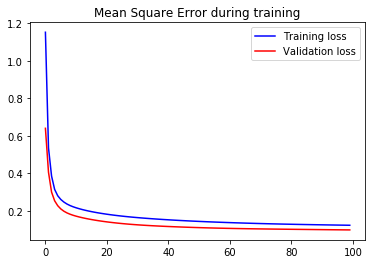

In [44]:
plot_train_history(single_step_sequential_history,
                   'Mean Square Error during training')

Compare trajectory

Trajectory component vs steps

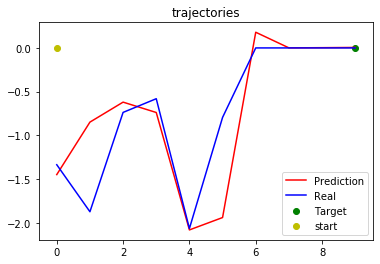

In [45]:
plt.figure()
S_Trajectory_prediction = single_step_sequential_model.predict(x_train_single_sequential)[:,:,:]

t_number = 5

component= 3

plt.plot(S_Trajectory_prediction[t_number][:,component], c='r', label='Prediction')
plt.plot(y_train_single_sequential[t_number][:,component], c='b', label='Real')
plt.scatter(N_STEPS-1, ZT_norm[component],  c='g', label='Target')
plt.scatter(0, x_train_single_sequential[t_number][0,component], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()

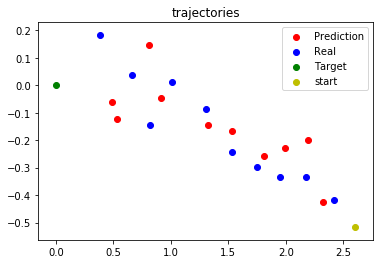

In [46]:
plt.figure()
S_Trajectory_prediction = single_step_sequential_model.predict(x_val_single_sequential)[:,:,0:2]

t_number = 10

plt.scatter(S_Trajectory_prediction[t_number][:,0], S_Trajectory_prediction[t_number][:,1], c='r', label='Prediction')
plt.scatter(y_val_single_sequential[t_number][:,0], y_val_single_sequential[t_number][:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(x_val_single_sequential[t_number][0,0], x_val_single_sequential[t_number][0,1], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()

## Decoder Mode

66.96232659149412


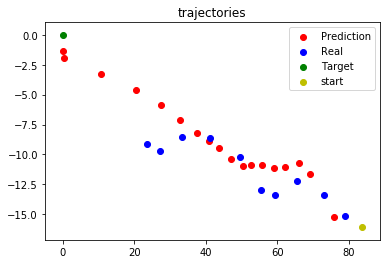

In [76]:
t_number = 44
S_Trajectory_prediction=x_val_single_sequential[t_number,0,:]
S_Trajectory_prediction = np.reshape(S_Trajectory_prediction, (1,1,6))

for i in range(20):

    dummy_trajectory=single_step_sequential_model.predict(S_Trajectory_prediction)
    last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

    if  (last_step[0,0,0] <= 0.01):
        last_step[0,0,0] = 0
        S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)
        break
    S_Trajectory_prediction=np.append(S_Trajectory_prediction, last_step, axis=1)

New_trajectory = np.squeeze(S_Trajectory_prediction)

Trajectory_prediction_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

y_val_denorm = np.apply_along_axis(denorm,1,y_val_single_sequential[t_number],data_stats)

x_val_denorm = np.apply_along_axis(denorm,1,x_val_single_sequential[t_number],data_stats)

min_len = min(len(y_val_denorm),len(Trajectory_prediction_denorm[1:]))

mse =sklearn.metrics.mean_squared_error(y_val_denorm[:min_len,0:2], Trajectory_prediction_denorm[1:min_len+1,0:2])

print(mse)


plt.figure()

plt.scatter(Trajectory_prediction_denorm[1:,0], Trajectory_prediction_denorm[1:,1], c='r', label='Prediction')
plt.scatter(y_val_denorm[:,0], y_val_denorm[:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(x_val_denorm[0,0], x_val_denorm[0,1], c='y', label='start')
plt.title("trajectories")
plt.legend()

plt.show()


In [48]:
def generate_trajectory_Decoder(model, start, target, initial_action, data_stats):

    model.reset_states()

    # initialize cost
    cost = 0

    # Empty vector to store the actions
    actions = []

    #initialize action vector
    actions.append(initial_action)

    # First point is the initial distance

    # Compute the initial distance
    distance_long = target - start
    
    # normalize to get the Neuronal Network input
    distance = norm(distance_long[0:6], data_stats)
    trajectory_generated = tf.expand_dims([distance], 0)


    for i in range(15):

        dummy_trajectory=model.predict(trajectory_generated)
        last_step = np.reshape(dummy_trajectory[:,-1,:],(1,1,6))

        if  (last_step[0,0,0] <= 0.02):
            last_step[0,0,0] = 0
            trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
            end_message = "End"
            break

        trajectory_generated=np.append(trajectory_generated, last_step, axis=1)
        end_message = "Error"
    
    print(end_message)

    New_trajectory = np.squeeze(trajectory_generated)

    trajectory_generated_denorm = np.apply_along_axis(denorm,1,New_trajectory,data_stats)

    return trajectory_generated_denorm, cost, actions, end_message


#### Adding early stop

In [49]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history_sequential = single_step_sequential_model.fit(train_data_single_sequential, epochs=EPOCHS,
                                          steps_per_epoch=STEPS_PER_EPOCH,
                                          validation_data=val_data_single_sequential,
                                          validation_steps=50, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1228,  mae:0.1955,  mse:0.1228,  val_loss:0.0981,  val_mae:0.1780,  val_mse:0.0981,  
....................................................................................................

In [50]:
single_step_sequential_model.save('./data/S2S_S2S_model_2.h5') 

## Get validation statistics

In [51]:
model = tf.keras.models.load_model('./data/S2S_S2S_model_2.h5')

In [52]:
def distance_error(x, z):
    distancia = math.sqrt(x**2 + z**2)
    return distancia

In [53]:
val_results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "end_message"])

for t_number in range(len(y_val_single_sequential)):

    x_val_denorm = np.apply_along_axis(denorm,1,x_val_single_sequential[t_number],data_stats)

    y_val_denorm = np.apply_along_axis(denorm,1,y_val_single_sequential[t_number],data_stats)

    initial_action = [0,0]
    start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
    target = x_val_denorm[0] + start

    start_time = time.time()

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    min_len = min(len(y_val_denorm),len(trajectory[1:]))

    mse =sklearn.metrics.mean_squared_error(y_val_denorm[:min_len,0:2], trajectory[1:min_len+1,0:2])

    val_results.at[t_number, "time"] = time.time() - start_time
    val_results.at[t_number, "actions"] = np.array(actions)
    val_results.at[t_number, "path"] = np.array(trajectory)
    val_results.at[t_number, "sqrt(Trajectory MSE)"] = math.sqrt(mse)
    val_results.at[t_number, "cost"] = cost
    val_results.at[t_number, 'distance'] = distance_error(*trajectory[-1,0:2])
    val_results.at[t_number, 'end_message'] = end_message



End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
Error
End
End
End


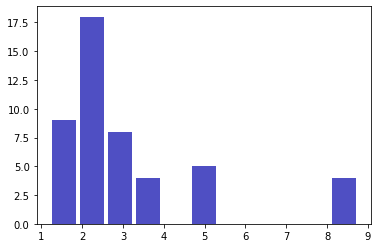

In [54]:

n, bins, patches = plt.hist(x=val_results["sqrt(Trajectory MSE)"], bins='auto', color='#0504aa', alpha=0.7, rwidth=0.85)

In [55]:
val_results

,path,actions,distance,cost,end_message,time,sqrt(Trajectory MSE)
0,"[[53.091276694430626, -21.57095630437822, -4.2...","[[0, 0]]",0.403314,0,End,3.510717,3.120910
1,"[[54.8408994487374, -27.692396223668613, -4.25...","[[0, 0]]",0.363365,0,End,0.283134,3.080674
2,"[[83.8765266289629, -9.328049475317627, -4.257...","[[0, 0]]",0.260284,0,End,4.150444,3.578336
3,"[[89.38301954752997, -22.56310849378207, -4.25...","[[0, 0]]",1.50963,0,End,0.432646,2.212665
4,"[[84.50727895488389, -37.25419505283933, -4.25...","[[0, 0]]",0.445078,0,End,0.420302,1.341755
5,"[[71.47798147570232, -22.98915443502045, -4.25...","[[0, 0]]",3.16179,0,End,0.368519,2.518434
6,"[[78.16317144157597, -8.378863535880196, -4.25...","[[0, 0]]",0.698886,0,End,0.607182,1.710588
7,"[[46.95093257513877, -15.291813618336832, -4.2...","[[0, 0]]",1.61593,0,End,0.293715,2.234861
8,"[[77.96030810811305, -23.275286441596784, -4.2...","[[0, 0]]",1.26538,0,End,0.461234,2.318930
9,"[[53.82516962303222, -4.976967885744467, -4.25...","[[0, 0]]",1.05715,0,End,0.652252,3.571439


In [56]:
val_table = pd.DataFrame(columns = ["all","result_end", "result_error"])

val_table.at['distance', "result_end"] = val_results['distance'].loc[val_results['end_message'] == "End"].mean()
val_table.at['distance', "result_error"] = val_results['distance'].loc[val_results['end_message'] == "Error"].mean()
val_table.at['distance', "all"] = val_results['distance'].mean()

val_table.at["time", "result_end"] = val_results["time"].loc[val_results['end_message'] == "End"].mean()
val_table.at["time", "result_error"] = val_results["time"].loc[val_results['end_message'] == "Error"].mean()
val_table.at["time", "all"] = val_results["time"].mean()

val_table.at["sqrt(Trajectory MSE)", "result_end"] = val_results["sqrt(Trajectory MSE)"].loc[val_results['end_message'] == "End"].mean()
val_table.at["sqrt(Trajectory MSE)", "result_error"] = val_results["sqrt(Trajectory MSE)"].loc[val_results['end_message'] == "Error"].mean()
val_table.at["sqrt(Trajectory MSE)", "all"] = val_results["sqrt(Trajectory MSE)"].mean()

print(val_results["time"].loc[val_results['end_message'] == "Error"].count()/len(y_val_single_sequential))
val_table


0.0625


,all,result_end,result_error
distance,2.32206,1.26662,18.1536
time,0.580643,0.5552,0.962284
sqrt(Trajectory MSE),3.18061,2.91077,7.22826


## Compare with heuristic results

In [57]:
from ast import literal_eval
samples = pd.read_csv("./data/heuristic_samples_metric.csv", converters={'initial_state': literal_eval, 'final_state': literal_eval, 'h_actions': literal_eval, 'h_path': literal_eval})

In [58]:
results= samples.copy()

In [59]:
col = ['D0','D1','D2','D3','D4','D5']
distances = []
for sample_id, row in samples.iterrows():
    target = np.array(results['final_state'][sample_id])
    for sample in  samples['h_path'][sample_id]:
        distances.append(target[0:6]-sample[0:6])
distances = np.array(distances)
df = pd.DataFrame (distances, columns = col)
data_stats_T = df.describe()
data_stats_T = data_stats_T.transpose()
data_stats_T

,count,mean,std,min,25%,50%,75%,max
D0,464.0,1037.949465,779.981979,0.001143,238.099339,1084.927422,1671.724701,2292.599315
D1,464.0,-109.969042,186.497363,-664.286328,-219.767671,-33.544771,0.406538,249.233041
D2,464.0,-0.690586,0.913037,-4.333594,-1.082213,-0.339180,-0.003143,0.998591
D3,464.0,-0.110996,0.075754,-0.272563,-0.175906,-0.134497,-0.029880,0.085473
D4,464.0,-0.015846,0.361746,-1.047180,-0.122068,0.000000,0.038481,1.047196
D5,464.0,0.004774,0.023279,-0.113255,-0.000477,0.000002,0.021459,0.058682


In [60]:
results= samples.copy()
for sample_id, row in results.iterrows():
    print(sample_id)
    initial_action = np.array(results['h_actions'][sample_id][0])
    start = np.array(results['initial_state'][sample_id])
    target = np.array(results['final_state'][sample_id])
    start_time = time.time()
    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
    results.at[sample_id, "h_time"] = time.time() - start_time
    results.at[sample_id, "h_actions"] = np.array(actions)
    results.at[sample_id, "h_path"] = np.array(trajectory)
    results.at[sample_id, "h_cost"] = cost
    results.at[sample_id, 'h_distance'] = distance_error(*trajectory[-1,0:2])
    results.at[sample_id, 'end_message'] = end_message

0
End
1
End
2
End
3
End
4
End
5
End
6
End
7
End
8
End
9
End
10
End
11
End
12
End
13
End
14
End
15
End
16
End
17
End
18
End
19
End
20
End
21
End
22
End
23
End
24
End
25
End
26
End
27
End
28
End
29
End
30
End
31
End
32
End
33
End
34
End
35
End
36
End
37
End
38
End
39
End
40
End
41
End
42
End
43
End
44
End
45
End
46
End
47
End
48
End
49
End
50
End
51
End
52
End
53
End
54
End
55
End
56
End
57
End
58
End
59
End
60
End
61
End
62
End
63
End
64
End
65
End
66
End
67
End
68
End
69
End
70
End
71
End
72
End
73
End
74
End
75
End
76
End
77
End
78
End
79
End
80
End
81
End
82
End
83
End
84
End
85
End
86
End
87
End
88
End
89
End
90
End
91
End
92
End
93
End
94
End
95
End
96
End
97
End
98
End
99
End


In [61]:
comparsion_table = pd.DataFrame(columns = ["sample", "result_end", "result_error", "all results"])
comparsion_table.at["h_cost", "sample"] = samples["h_cost"].mean()
comparsion_table.at["h_cost", "result_end"] = results["h_cost"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_cost", "result_error"] = results["h_cost"].loc[results['end_message'] == "Error"].mean()

comparsion_table.at['h_distance', "sample"] = samples['h_distance'].mean()
comparsion_table.at['h_distance', "result_end"] = results['h_distance'].loc[results['end_message'] == "End"].mean()
comparsion_table.at['h_distance', "result_error"] = results['h_distance'].loc[results['end_message'] == "Error"].mean()
comparsion_table.at['h_distance', "all results"] = results['h_distance'].mean()

comparsion_table.at['h_time', "sample"] = samples["h_time"].mean()
comparsion_table.at["h_time", "result_end"] = results["h_time"].loc[results['end_message'] == "End"].mean()
comparsion_table.at["h_time", "result_error"] = results["h_time"].loc[results['end_message'] == "Error"].mean()
comparsion_table.at["h_time", "all results"] = results["h_time"].mean()
print(results["h_time"].loc[results['end_message'] == "Error"].count())
comparsion_table



0


,sample,result_end,result_error,all results
h_cost,5215.39,0,NaN,NaN
h_distance,3.95573,20.7398,NaN,20.7398
h_time,388.612,0.510404,NaN,0.510404


## Plot one single trajectory

End
[2048.80449952 2112.77526448 1839.56314048 1591.55484472 1189.20025142
  692.28020907  291.67119641   55.2430455     0.        ]


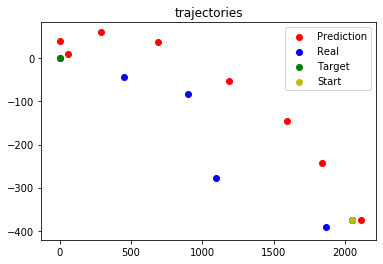

In [62]:
sample_id = 7
initial_action = np.array(samples['initial_state'][sample_id][6:8])
start = np.array(samples['initial_state'][sample_id][0:6])
target = np.array(samples['final_state'][sample_id][0:6])
distancia_inicial = target - start
teorico = []
for sample in  samples['h_path'][sample_id]:
    teorico.append(sample[0:6])
teorico = np.array(teorico)

trajectory, cost, actions, end_message= generate_trajectory_Decoder(model, start, target, initial_action, data_stats_T)
trajectory = np.array(trajectory)
print(trajectory[:,0])

plt.figure()

plt.scatter(trajectory[:,0], trajectory[:,1], c='r', label='Prediction')
plt.scatter(teorico[:,0], teorico[:,1], c='b', label='Real')
plt.scatter(ZT_norm[0],ZT_norm[1], c='g', label='Target')
plt.scatter(distancia_inicial[0],distancia_inicial[1], c='y', label='Start')
plt.title("trajectories")
plt.legend()

plt.show()



## Datos globales

In [63]:
TRAIN_SPLIT = len(dataset2)
past_history = N_STEPS
future_target = 0
STEP = N_STEPS+1
prediction_type ="sequence"
features_dataset = dataset2[:,:,:6]
target_dataset = dataset2[:,0:,:6]

x_full_single_sequential, y_full_single_sequential = multivariate_data(features_dataset, target_dataset,0, TRAIN_SPLIT, past_history, future_target, STEP, prediction_type)


In [64]:
full_results = pd.DataFrame(columns = ["path", "actions", "distance", "cost", "end_message","k_value"])

for t_number in range(len(y_full_single_sequential)):

    x_full_denorm = np.apply_along_axis(denorm,1,x_full_single_sequential[t_number],data_stats)

    y_full_denorm = np.apply_along_axis(denorm,1,y_full_single_sequential[t_number],data_stats)

    initial_action = [0,0]
    start = [0.0, 0.0, 4.257165346815115, 0.0, 0, 0]
    target = x_full_denorm[0] + start

    start_time = time.time()

    trajectory, cost, actions, end_message = generate_trajectory_Decoder(model, start, target, initial_action, data_stats)

    min_len = min(len(y_full_denorm),len(trajectory[1:]))

    mse =sklearn.metrics.mean_squared_error(y_full_denorm[:min_len,0:2], trajectory[1:min_len+1,0:2])

    full_results.at[t_number, "time"] = time.time() - start_time
    full_results.at[t_number, "actions"] = np.array(actions)
    full_results.at[t_number, "path"] = np.array(trajectory)
    full_results.at[t_number, "sqrt(Trajectory MSE)"] = math.sqrt(mse)
    full_results.at[t_number, "cost"] = cost
    full_results.at[t_number, 'distance'] = distance_error(*trajectory[-1,0:2])
    full_results.at[t_number, 'end_message'] = end_message
    full_results.at[t_number, 'k_value'] = abs(target[1])/abs(target[0])

End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
End
Error
Error
End
End
End


In [65]:
full_results

,path,actions,distance,cost,end_message,k_value,time,sqrt(Trajectory MSE)
0,"[[57.49322520624957, -23.845599547629394, -4.2...","[[0, 0]]",2.90085,0,End,0.414755,0.321743,2.762909
1,"[[38.074381614290274, -4.714209816488492, -4.2...","[[0, 0]]",0.468808,0,End,0.123816,0.275969,1.189325
2,"[[79.48363736061964, -25.738416777370606, -4.2...","[[0, 0]]",1.29466,0,End,0.32382,0.363137,2.715180
3,"[[65.56259184933506, -16.18398431245977, -4.25...","[[0, 0]]",1.80254,0,End,0.246848,0.356879,4.013849
4,"[[74.06906172873424, -10.786261281604817, -4.2...","[[0, 0]]",1.34681,0,End,0.145624,0.583579,5.792465
...,...,...,...,...,...,...,...,...
235,"[[83.52663655716658, -14.379154946211687, -4.2...","[[0, 0]]",14.6309,0,Error,0.172151,0.765282,8.640027
236,"[[83.56825626542957, -16.064606943463133, -4.2...","[[0, 0]]",20.8577,0,Error,0.192233,1.070278,8.183051
237,"[[65.45650918893115, -5.4304922989753095, -4.2...","[[0, 0]]",1.66068,0,End,0.0829634,0.798864,5.274354
238,"[[49.18654403451268, -32.05385577564188, -4.25...","[[0, 0]]",2.59798,0,End,0.651679,0.334106,1.717082


In [66]:
full_results['distance'].loc[full_results['k_value'] > 0.25].mean()

1.6608801623867078

In [67]:
full_results['distance'].loc[full_results['k_value'] < 0.25].mean()

3.3650417416832337

In [68]:
full_results["sqrt(Trajectory MSE)"].loc[full_results['k_value'] < 0.25].mean()

4.729938301275408

In [69]:
full_results["sqrt(Trajectory MSE)"].loc[full_results['k_value'] > 0.25].mean()

2.5170817569092674

In [70]:
full_results['distance'].std()

4.375892271686531

In [71]:
full_results['distance'].mean()

2.20763200241101